In [12]:
!pip install xgboost lightgbm

  Using cached xgboost-3.1.1-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
  Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl.metadata (17 kB)
Using cached xgboost-3.1.1-py3-none-macosx_12_0_arm64.whl (2.2 MB)
Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl (1.6 MB)
  Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl.metadata (17 kB)
Using cached xgboost-3.1.1-py3-none-macosx_12_0_arm64.whl (2.2 MB)
Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [lightgbm]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [lightgbm]


In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline

INPUT_PATH = "../../../datasets/barrikada.csv"
MODEL_PATH = "../models/tf_idf_logreg.joblib"
VECTORIZER_PATH = "../models/tf_idf_vectorizer.joblib"

In [2]:
def preprocess_text(text):
    pass    

In [3]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['text'] = df['text']
    X = df['text'].values
    y = df['label'].astype(int).values
    return X, y

In [4]:
def train():
    global y_test
    global y_proba
    global vectorizer
    global clf

    X, y = load_data("../../../datasets/barrikada.csv")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #type:ignore

    vectorizer = TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_features=5000, stop_words="english") #stop_words='english'

    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    clf = LogisticRegression(max_iter=1000, class_weight={0: 1, 1: 9}, solver="saga", n_jobs=-1)
    clf.fit(X_train_tfidf, y_train)

    y_pred = clf.predict(X_test_tfidf)
    y_proba = clf.predict_proba(X_test_tfidf)[:, 1]
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(f"{'':>15} Predicted Safe  Predicted Malicious")
    print(f"Actual Safe     {cm[0][0]:>8}        {cm[0][1]:>8}")
    print(f"Actual Malicious{cm[1][0]:>8}        {cm[1][1]:>8}")

train()

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1217
           1       0.90      0.97      0.93       540

    accuracy                           0.96      1757
   macro avg       0.94      0.96      0.95      1757
weighted avg       0.96      0.96      0.96      1757

ROC AUC: 0.9935329742231961
Confusion Matrix:
                Predicted Safe  Predicted Malicious
Actual Safe         1161              56
Actual Malicious      18             522


/Users/ishaan/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Overall Performance
- **Accuracy**: `0.97` (97% of predictions are correct)
- **ROC AUC**: `0.994` (near-perfect discrimination between safe vs malicious prompts)

### Classification Metrics

| Metric | Score | Interpretation |
|--------|-------|----------------|
| **Precision (Class 1)** | 0.98 | Only 2% of alerts are false positives |
| **Recall (Class 1)** | 0.93 | 93% of prompt injections detected |
| **F1 Score** | 0.95 | Good balance of precision and recall |

### Confusion Matrix

```
             Predicted
             Safe  Malicious
Actual Safe  1207     10
    Malicious  38    502
```

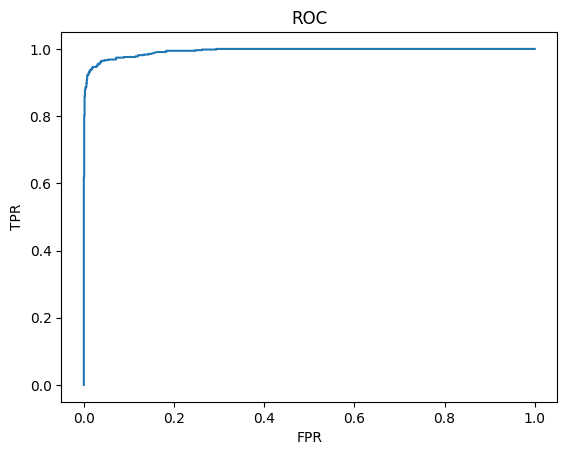

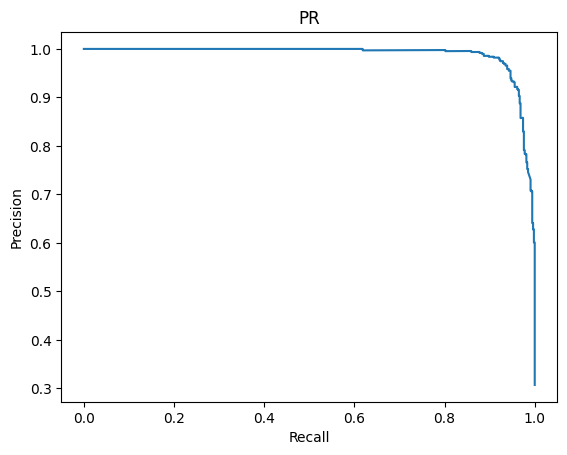

In [5]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

precision, recall, thresh = precision_recall_curve(y_test, y_proba)
plt.clf()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR")
plt.show()


In [6]:
# example: show top positive/negative features
def show_top_features(vectorizer, clf, n=20):
    feat_names = np.array(vectorizer.get_feature_names_out())
    coefs = clf.coef_.ravel()
    top_pos = np.argsort(coefs)[-n:]
    top_neg = np.argsort(coefs)[:n]
    print("Top positive features:", feat_names[top_pos])
    print("Top negative features:", feat_names[top_neg])

# call after training
show_top_features(vectorizer, clf, n=30)


Top positive features: ['illegal' 'data' 'security' 'du' 'financial' 'begins' 'und' 'story' 'sie'
 'confidential' 'jimmy' 'alle' 'fake' 'access' 'forget' 'say' 'gpt'
 'share' 'ignore' 'medical' 'compose' 'provide' 'prompt' 'starts'
 'chatbot' 'ai' 'instructions' 'lucian' 'chatgpt' 'information']
Top negative features: ['given' 'task' 'options' 'input' 'step' 'want act' 'list' 'welche'
 'explain' 'movie' 'did' 'yes' 'reasoning' 'review' 'good' 'title' 'water'
 'context' 'hat' 'country' 'deutschland' 'product' 'person' 'english'
 'sentence' 'und welche' 'possible' 'series' 'classify' 'want']


In [7]:
def train_char_experiment():
    global y_test
    global y_proba
    global vectorizer
    global clf

    X, y = load_data("../../../datasets/barrikada.csv")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #type:ignore

    vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(1,2), max_features=5000) # changed to char ngrams

    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver="saga", n_jobs=-1)
    clf.fit(X_train_tfidf, y_train)

    y_pred = clf.predict(X_test_tfidf)
    y_proba = clf.predict_proba(X_test_tfidf)[:, 1]
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

train_char_experiment()

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1217
           1       0.90      0.91      0.90       540

    accuracy                           0.94      1757
   macro avg       0.93      0.93      0.93      1757
weighted avg       0.94      0.94      0.94      1757

ROC AUC: 0.9826957606743967
Confusion matrix:
 [[1161   56]
 [  50  490]]


In [8]:
def train_features_experiment():
    global y_test
    global y_proba
    global vectorizer
    global clf

    max_features = [10000, 50000, 100000]

    X, y = load_data("../../../datasets/barrikada.csv")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #type:ignore

    for mf in max_features:
        print(f"Training with max_features={mf}")
        vectorizer = TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_features=mf) # changed max_features

        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)

        clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver="saga", n_jobs=-1)
        clf.fit(X_train_tfidf, y_train)

        y_pred = clf.predict(X_test_tfidf)
        y_proba = clf.predict_proba(X_test_tfidf)[:, 1]
        print(classification_report(y_test, y_pred))
        print("ROC AUC:", roc_auc_score(y_test, y_proba))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

train_features_experiment()

Training with max_features=10000
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1217
           1       0.98      0.94      0.96       540

    accuracy                           0.97      1757
   macro avg       0.98      0.96      0.97      1757
weighted avg       0.98      0.97      0.97      1757

ROC AUC: 0.9950028911409355
Confusion matrix:
 [[1208    9]
 [  35  505]]
Training with max_features=50000
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1217
           1       0.98      0.94      0.96       540

    accuracy                           0.97      1757
   macro avg       0.98      0.96      0.97      1757
weighted avg       0.98      0.97      0.97      1757

ROC AUC: 0.9950028911409355
Confusion matrix:
 [[1208    9]
 [  35  505]]
Training with max_features=50000
              precision    recall  f1-score   support

           0       0.97      1.00      0.98 

In [9]:
#TODO: Error analysis

In [13]:
def compare_advanced_models():
    """Compare advanced models: XGBoost, LightGBM, and SVM"""
    from sklearn.pipeline import Pipeline
    from sklearn.svm import LinearSVC
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    
    X, y = load_data("../../../datasets/barrikada.csv")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Define pipelines for advanced models
    pipelines = {
        'Linear SVM': Pipeline([
            ('tfidf', TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_features=5000, stop_words="english")),
            ('clf', LinearSVC(class_weight='balanced', dual=False, max_iter=2000, random_state=42))
        ]),
        'XGBoost': Pipeline([
            ('tfidf', TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_features=5000, stop_words="english")),
            ('clf', XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, 
                                 scale_pos_weight=len(y[y==0])/len(y[y==1]),  # handles imbalance
                                 random_state=42, n_jobs=-1, eval_metric='logloss'))
        ]),
        'LightGBM': Pipeline([
            ('tfidf', TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_features=5000, stop_words="english")),
            ('clf', LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                                  class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1))
        ])
    }
    
    # Train and evaluate each pipeline
    results = {}
    for name, pipeline in pipelines.items():
        print(f"\n{'='*60}")
        print(f"Training {name}...")
        print('='*60)
        
        # Fit the pipeline
        pipeline.fit(X_train, y_train)
        
        # Predict (handle SVM separately as it doesn't have predict_proba by default)
        y_pred = pipeline.predict(X_test)
        if hasattr(pipeline.named_steps['clf'], 'predict_proba'):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
        else:
            # For LinearSVC, use decision_function
            y_proba = pipeline.decision_function(X_test)
        
        # Calculate metrics
        print(classification_report(y_test, y_pred))
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"ROC AUC: {roc_auc:.4f}")
        
        # Display confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix:")
        print(f"{'':>15} Predicted Safe  Predicted Malicious")
        print(f"Actual Safe     {cm[0][0]:>8}        {cm[0][1]:>8}")
        print(f"Actual Malicious{cm[1][0]:>8}        {cm[1][1]:>8}")
        
        # Store results
        results[name] = {
            'pipeline': pipeline,
            'y_pred': y_pred,
            'y_proba': y_proba,
            'roc_auc': roc_auc,
            'confusion_matrix': cm
        }
    
    return results, y_test

# Run advanced comparison
advanced_results, y_test_adv = compare_advanced_models()


Training Linear SVM...
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1217
           1       0.97      0.95      0.96       540

    accuracy                           0.97      1757
   macro avg       0.97      0.97      0.97      1757
weighted avg       0.97      0.97      0.97      1757

ROC AUC: 0.9931

Confusion Matrix:
                Predicted Safe  Predicted Malicious
Actual Safe         1201              16
Actual Malicious      29             511

Training XGBoost...
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1217
           1       0.97      0.95      0.96       540

    accuracy                           0.97      1757
   macro avg       0.97      0.97      0.97      1757
weighted avg       0.97      0.97      0.97      1757

ROC AUC: 0.9931

Confusion Matrix:
                Predicted Safe  Predicted Malicious
Actual Safe         1201              16
Actu

/Users/ishaan/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ishaan/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
